In [2]:
#import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from xgboost import XGBRegressor

import sklearn.metrics as metrics
from scipy.stats import norm,skew

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [4]:
train.shape , test.shape

((1460, 81), (1459, 80))

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Many missing values 

##

## Lets explore target === SalePrice

In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

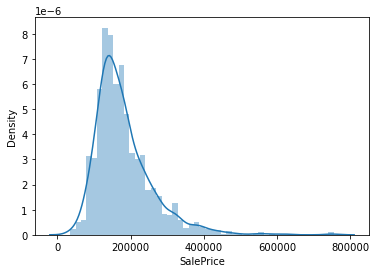

In [9]:
sns.distplot(train['SalePrice'])

We have a positive skew and we must fix it

In [11]:
print("Skewness :%f" % train['SalePrice'].skew())
print("Kurtosis :%f" % train['SalePrice'].kurt())


Skewness :1.882876
Kurtosis :6.536282


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

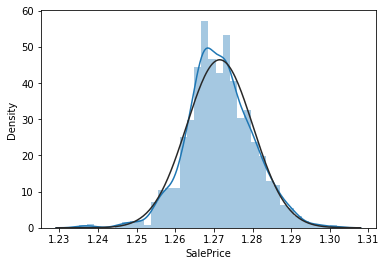

In [14]:
#fix skewness by changing y=x ====> y=log(1+x)

train['SalePrice']=np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit =norm)

#fit = norm draws an extra normal distribution curve

# Data exploration using seamap cuz we not brokers who know best features

<AxesSubplot:>

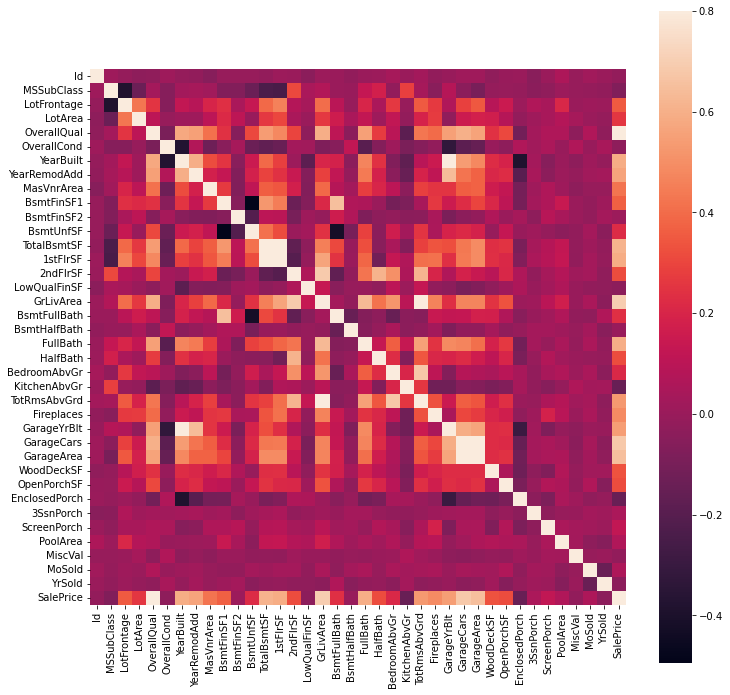

In [38]:
corrmat= train.corr()

f,ax=plt.subplots(figsize=(12,12))

#vmax is max correlation 
sns.heatmap(corrmat,vmax=.8,square=True)

Ok, now as you see the correlation between features.. The colours show to us the strong and weak correlation.
But what we really need? we need the highest correlation between features and SalesPrice, so let's do it.

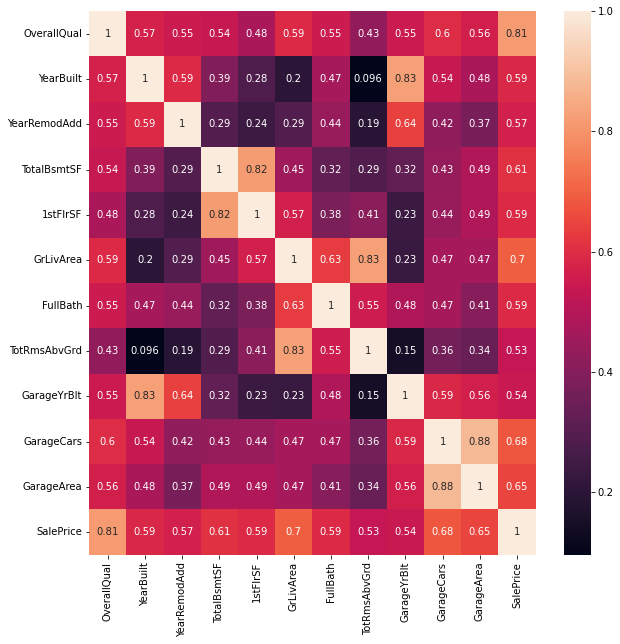

In [20]:
corr=train.corr()
highest_corr_features= corr.index[abs(corr['SalePrice'])>0.5]

plt.figure(figsize=(10,10))
g=sns.heatmap(train[highest_corr_features].corr(),annot=True)

- We note the highest corr is 0.81 'OverallQual'
- 'GarageCars' and 'GarageArea' have same correlation
- 'TotalBsmtSF' & '1stFlrSF' also like each other (correlation betwwen them is 0.82), so we can keep either one of them or add the1stFlrSF to the Toltal.
- 'TotRmsAbvGrd' & 'GrLivArea' also has a strong correlation (0.83), I decided to keep 'GrLivArea' because it's correlation with 'SalePrice' is higher.



In [21]:
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.814276
GrLivArea        0.695805
GarageCars       0.679921
GarageArea       0.649144
TotalBsmtSF      0.608216
FullBath         0.593615
1stFlrSF         0.592491
YearBuilt        0.588223
YearRemodAdd     0.567048
GarageYrBlt      0.542977
TotRmsAbvGrd     0.531271
Fireplaces       0.488114
MasVnrArea       0.423820
BsmtFinSF1       0.368869
LotFrontage      0.353819
WoodDeckSF       0.332759
OpenPorchSF      0.318060
2ndFlrSF         0.317181
HalfBath         0.314768
LotArea          0.254799
BsmtFullBath     0.235507
BsmtUnfSF        0.220688
BedroomAbvGr     0.212503
ScreenPorch      0.121505
PoolArea         0.068063
MoSold           0.057424
3SsnPorch        0.055434
BsmtFinSF2       0.006648
BsmtHalfBath    -0.003184
Id              -0.017136
MiscVal         -0.019917
OverallCond     -0.030861
YrSold          -0.038074
LowQualFinSF    -0.038592
MSSubClass      -0.072020
KitchenAbvGr    -0.147098
EnclosedPorch   -0.150062
Name: SalePr

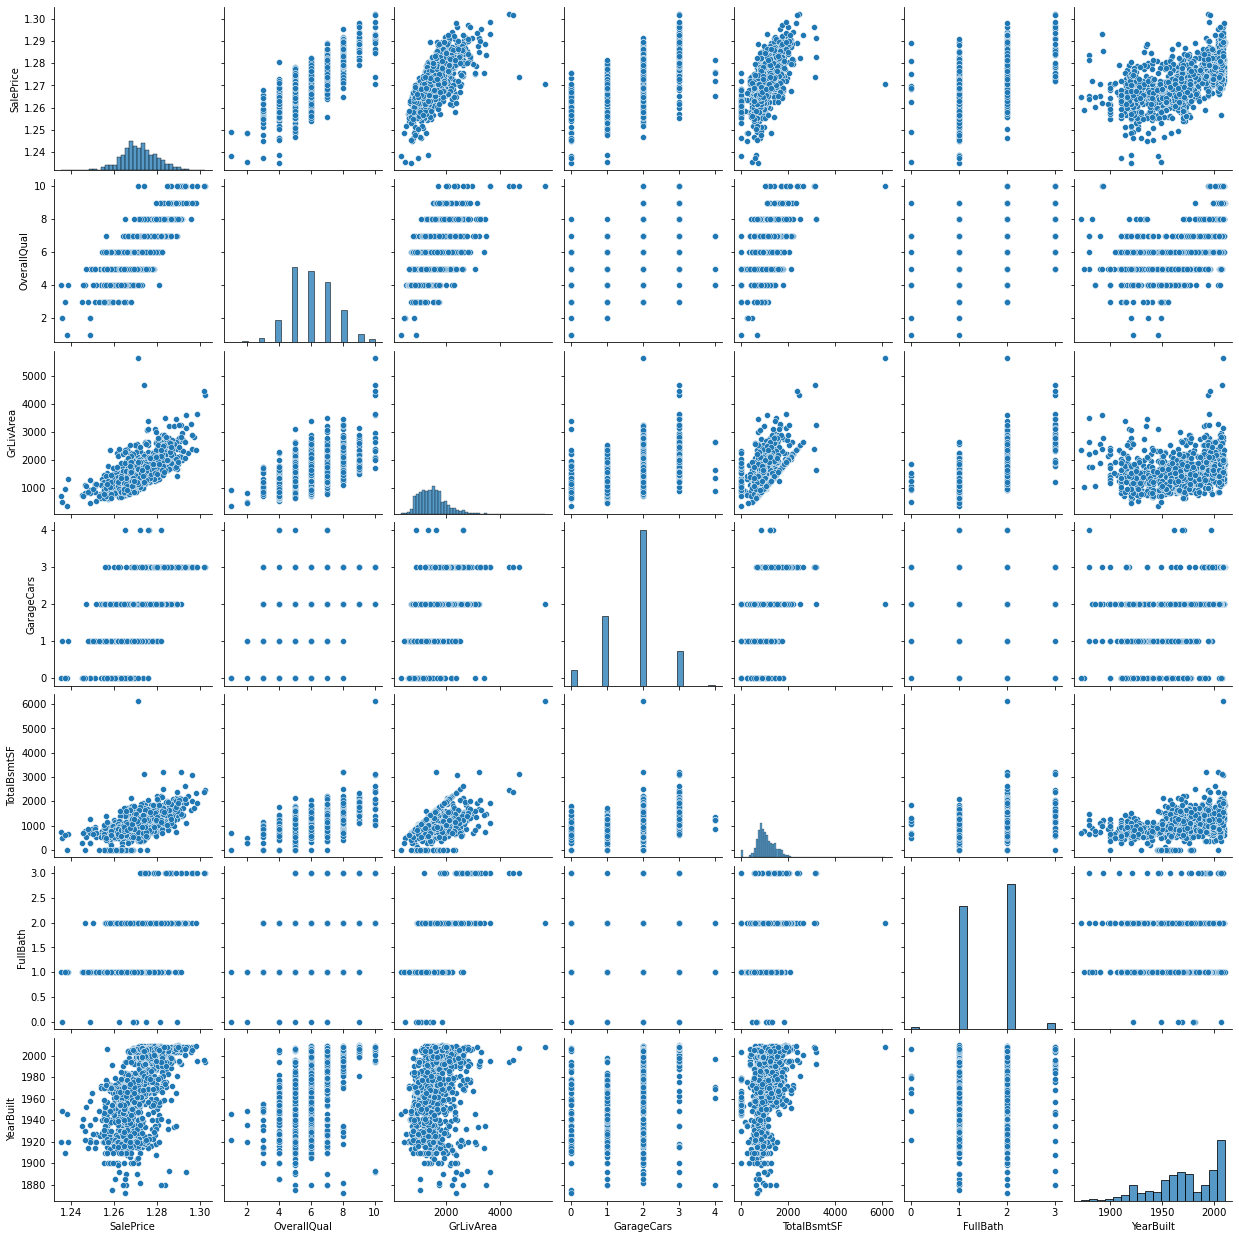

In [22]:
#features with highest correlation
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

In [24]:
#looking for missing data
#concatenate test and train data to preprocess the divide them again



y_train=train['SalePrice']
test_id=test['Id']
all_data=pd.concat([train,test],axis=0,sort=False)
all_data=all_data.drop(['Id','SalePrice'],axis=1)

In [27]:
Total=all_data.isnull().sum().sort_values(ascending=False)
#find total no of null values

percent=(all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([Total,percent],axis=1,keys=['Total','Percent'])

missing_data.head(25)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


Well, if we look at these features that have many missing values, we will note that they are not important features, none of them has (correlation > 0.5), so if we delete them we will not miss the data.

In [28]:
all_data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
print(all_data.isnull().sum().max())

4


In [31]:
total=all_data.isnull().sum().sort_values(ascending=False)

In [33]:
total.head(20)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

In [35]:
#filling numeric data
numeric_missed = ['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'GarageArea',
                  'GarageCars']
for feature in numeric_missed:
    all_data[feature]=all_data[feature].fillna(all_data[feature].mean())

In [36]:
#filling categorical data
categorical_missed = ['Exterior1st',
                  'Exterior2nd',
                  'SaleType',
                  'MSZoning',
                   'Electrical',
                     'KitchenQual']

for feature in categorical_missed:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0])

In [37]:
#Fill in the remaining missing values with the values that are most common for this feature.

all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [39]:
all_data.drop(['Utilities'], axis=1, inplace=True)


In [40]:
all_data.isnull().sum().max() #just checking that there's no missing data missing...


0

# FETAURE ENGINEERING 

Fix skewness in other features

In [42]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skew_feats=all_data[numeric_feats].apply(lambda x:skew(x)).sort_values(ascending=False)
high_skew=skew_feats[abs(skew_feats)>0.5]
high_skew

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146034
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931343
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425233
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162484
BsmtUnfSF         0.919508
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.623955
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [43]:
for feature in high_skew.index:
    all_data[feature]=np.log1p(all_data[feature])

In [44]:
#add new features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#

In [45]:
#convert categorical to numerical data

all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,...,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,2.197225,0.000000,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,20.257977,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,14.282490,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,20.415959,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,2.079442,0.693147,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,20.127741,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,21.048414,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [46]:
x_train=all_data[:len(y_train)]
x_test=all_data[len(y_train):]


In [47]:
x_test.shape,x_train.shape

((1459, 219), (1460, 219))

In [48]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [61]:
import xgboost as XGB

the_model = XGB.XGBRegressor(
    colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1
)
the_model.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4603,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0468, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             predictor='auto', random_state=7, reg_alpha=0.464, ...)

In [62]:
y_predict = np.expm1(the_model.predict(x_test))
y_predict[:5]


array([2.5657892, 2.5657892, 2.5657892, 2.5657892, 2.5657892],
      dtype=float32)